# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from PIL import Image

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon


### Change directory

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/R9_internal_lab/')

### Load the training data from train.csv file

In [0]:
df=pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [0]:
df.shape

(173, 8)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
filename    173 non-null object
width       173 non-null int64
height      173 non-null int64
class       173 non-null object
xmin        173 non-null int64
ymin        173 non-null int64
xmax        173 non-null int64
ymax        173 non-null int64
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


In [0]:
! pip install rarfile

In [0]:
from rarfile import RarFile
with RarFile('images_racoon.rar', 'r') as z:
  z.extractall()

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
 # SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96

EPOCHS = 30 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.
PATIENCE = 50 # Patience for early stopping

MULTI_PROCESSING = False # I have a 2 core computer without GPU
THREADS = 1 # I have a 2 core computer without GPU

DATASET_FOLDER = "/content/drive/My Drive/R9_internal_lab/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
print(TRAIN_CSV)

/content/drive/My Drive/R9_internal_lab/train_labels.csv


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
               
        for i, r in enumerate(row): # Parse row with seven entities
                 # if ((r=='raccoon')):
                    
                  #  row[i] = int(r)
              
          path,image_width,image_height,_, x0, y0, x1, y1 = row  
        coords[col, 0] = int(x0) * int(IMAGE_SIZE) / int(image_width) # Normalize bounding box by image size
        coords[col, 1] = int(y0) * int(IMAGE_SIZE) / int(image_height) # Normalize bounding box by image size
        coords[col, 2] = int(x1) * int(IMAGE_SIZE) / int(image_width) # Normalize bounding box by image size
        coords[col, 3] = int(y1) * int(IMAGE_SIZE) / int(image_height)
        paths.append(path)
                    


In [0]:
len(paths)

173

In [0]:
paths

['raccoon-17.jpg',
 'raccoon-11.jpg',
 'raccoon-63.jpg',
 'raccoon-63.jpg',
 'raccoon-60.jpg',
 'raccoon-69.jpg',
 'raccoon-180.jpg',
 'raccoon-200.jpg',
 'raccoon-141.jpg',
 'raccoon-19.jpg',
 'raccoon-84.jpg',
 'raccoon-124.jpg',
 'raccoon-182.jpg',
 'raccoon-111.jpg',
 'raccoon-91.jpg',
 'raccoon-79.jpg',
 'raccoon-93.jpg',
 'raccoon-20.jpg',
 'raccoon-42.jpg',
 'raccoon-139.jpg',
 'raccoon-58.jpg',
 'raccoon-71.jpg',
 'raccoon-183.jpg',
 'raccoon-1.jpg',
 'raccoon-169.jpg',
 'raccoon-82.jpg',
 'raccoon-4.jpg',
 'raccoon-101.jpg',
 'raccoon-10.jpg',
 'raccoon-166.jpg',
 'raccoon-184.jpg',
 'raccoon-38.jpg',
 'raccoon-120.jpg',
 'raccoon-142.jpg',
 'raccoon-149.jpg',
 'raccoon-51.jpg',
 'raccoon-43.jpg',
 'raccoon-123.jpg',
 'raccoon-66.jpg',
 'raccoon-9.jpg',
 'raccoon-178.jpg',
 'raccoon-47.jpg',
 'raccoon-167.jpg',
 'raccoon-54.jpg',
 'raccoon-77.jpg',
 'raccoon-155.jpg',
 'raccoon-89.jpg',
 'raccoon-153.jpg',
 'raccoon-179.jpg',
 'raccoon-115.jpg',
 'raccoon-64.jpg',
 'raccoon-56

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
os.getcwd()

'/content/drive/My Drive/R9_internal_lab'

In [0]:
image_path='/content/drive/My Drive/R9_internal_lab/images/'

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
  print(f)
  img = Image.open(image_path+f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
        
          

raccoon-17.jpg
raccoon-11.jpg
raccoon-63.jpg
raccoon-63.jpg
raccoon-60.jpg
raccoon-69.jpg
raccoon-180.jpg
raccoon-200.jpg
raccoon-141.jpg
raccoon-19.jpg
raccoon-84.jpg
raccoon-124.jpg
raccoon-182.jpg
raccoon-111.jpg
raccoon-91.jpg
raccoon-79.jpg
raccoon-93.jpg
raccoon-20.jpg
raccoon-42.jpg
raccoon-139.jpg
raccoon-58.jpg
raccoon-71.jpg
raccoon-183.jpg
raccoon-1.jpg
raccoon-169.jpg
raccoon-82.jpg
raccoon-4.jpg
raccoon-101.jpg
raccoon-10.jpg
raccoon-166.jpg
raccoon-184.jpg
raccoon-38.jpg
raccoon-120.jpg
raccoon-142.jpg
raccoon-149.jpg
raccoon-51.jpg
raccoon-43.jpg
raccoon-123.jpg
raccoon-66.jpg
raccoon-9.jpg
raccoon-178.jpg
raccoon-47.jpg
raccoon-167.jpg
raccoon-54.jpg
raccoon-77.jpg
raccoon-155.jpg
raccoon-89.jpg
raccoon-153.jpg
raccoon-179.jpg
raccoon-115.jpg
raccoon-64.jpg
raccoon-56.jpg
raccoon-44.jpg
raccoon-39.jpg
raccoon-26.jpg
raccoon-162.jpg
raccoon-170.jpg
raccoon-187.jpg
raccoon-131.jpg
raccoon-174.jpg
raccoon-92.jpg
raccoon-193.jpg
raccoon-138.jpg
raccoon-157.jpg
raccoon-108.j

In [0]:
len(batch_images)

173

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords[1:]
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou
    

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128   

In [0]:
model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)

Train on 173 samples
Epoch 1/30
173/173 [==============================] - 5s 30ms/sample - loss: 4154.1082 - IoU: 0.0711
Epoch 2/30
173/173 [==============================] - 5s 27ms/sample - loss: 858.8522 - IoU: 0.3916
Epoch 3/30
173/173 [==============================] - 5s 27ms/sample - loss: 469.6140 - IoU: 0.5578
Epoch 4/30
173/173 [==============================] - 5s 27ms/sample - loss: 650.6145 - IoU: 0.5120
Epoch 5/30
173/173 [==============================] - 5s 27ms/sample - loss: 431.2299 - IoU: 0.5817
Epoch 6/30
173/173 [==============================] - 5s 27ms/sample - loss: 251.3386 - IoU: 0.6180
Epoch 7/30
173/173 [==============================] - 5s 27ms/sample - loss: 266.5930 - IoU: 0.6180
Epoch 8/30
173/173 [==============================] - 5s 27ms/sample - loss: 233.5696 - IoU: 0.6335
Epoch 9/30
173/173 [==============================] - 5s 27ms/sample - loss: 181.7304 - IoU: 0.6843
Epoch 10/30
173/173 [==============================] - 5s 27ms/sample - loss: 

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/R9_internal_lab/images/images/raccoon-178.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

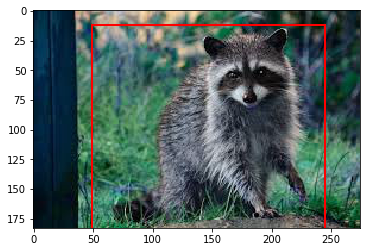

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Change your present working directory

In [0]:
import os
path = "/content/drive/My Drive/R9_internal_lab/"
os.chdir(path)

### Load your data file

In [0]:
import pandas as pd
df = pd.read_csv('daily-minimum-temperatures-in-me.csv',index_col='Date')

#### Plot data

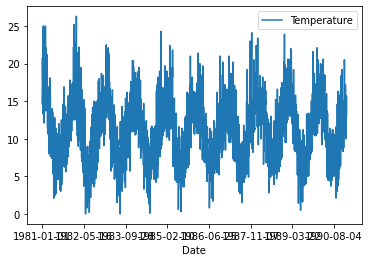

In [6]:
df.plot()

#### Descibe your dataframe

In [7]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [8]:
print(df.isnull().sum())

Temperature    0
dtype: int64


#### Drop null values

In [9]:
df.dropna(inplace=True)
df.isnull().sum()

Temperature    0
dtype: int64

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8053318080>]],
      dtype=object)

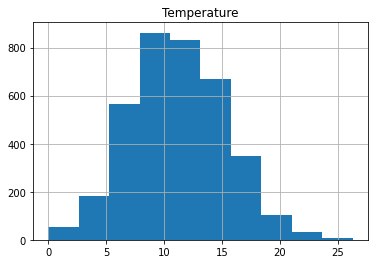

In [10]:
df.hist()

#### Check the maximum and minimum values

In [12]:
import numpy as np

print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')

#### Check the maximum and minimum values of scaled data

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [15]:
print(scaled[:5])

[[0.7870723]
 [0.6806084]
 [0.7148289]
 [0.5551331]
 [0.6007605]]


### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [17]:
len(train)

2920

In [18]:
len(test)

730

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [20]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2920 1
730 1


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2918, 1, 1)
(728, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras.models import Sequential      
from keras.layers import Dense,LSTM
from keras.layers.wrappers import TimeDistributed     
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [26]:
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0186
Epoch 2/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0105
Epoch 3/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0102
Epoch 4/10
2918/2918 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 5/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0101
Epoch 6/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0102
Epoch 7/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0101
Epoch 8/10
2918/2918 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 9/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0101
Epoch 10/10
2918/2918 [==============================] - 4s 1ms/step - loss: 0.0101


## Make Predictions and Evaluate your model

In [27]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)

y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)

y_test = scaler.inverse_transform([y_test])
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))

print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.41 RMSE


## Plot the results

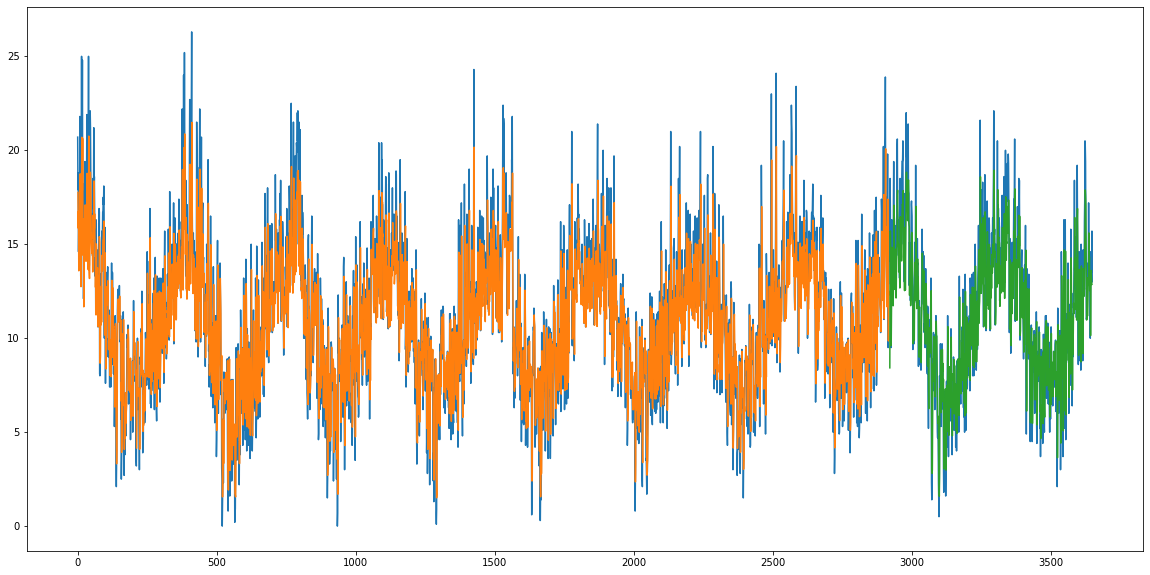

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting

testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict

plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()